In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
from envs.blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    给定一个Q函数和epsilon，构建一个ε-贪婪的策略
    
    参数:
        Q: 一个dictionary其key-value是state -> action-values.
            key是状态s，value是一个长为nA(Action个数)的numpy数组，表示采取行为a的概率。
        epsilon:  float 
        nA: action的个数
    
    返回值:
        返回一个 函数，这个函数的输入是一个状态/观察(observation)，输出是一个长度为nA的numpy数组，表示采取不同Action的概率

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    使用Epsilon-贪婪策略的蒙特卡罗控制，用了找到最优的epsilon-greedy策略
    
    参数:
        env: OpenAI gym environment
        num_episodes: 采样的episode个数
        discount_factor: 打折因子
        epsilon: Float
    
    返回:
        一个tuple(Q, policy).
        Q函数 state -> action values。key是状态，value是长为nA的numpy数组，表示Q(s,a)
        policy 最优的策略函数，输入是状态，输出是nA长的numpy数组，表示采取不同action的概率
    """
    
    # 记录每个状态的回报累加值和次数
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # Q函数state -> (action -> action-value)。key是状态s，value又是一个dict，其key是a，value是Q(s,a)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # epsilon-贪婪的策略
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 生成一个episode。
        # 一个episode是一个数组，每个元素是一个三元组(state, action, reward)
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # 找到episode里出现的所有(s,a)对epsilon。把它变成tuple以便作为dict的key。
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # 找到(s,a)第一次出现的下标
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # 计算(s,a)的回报
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # 累计计数
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # 策略已经通过Q“隐式”的提高了！
    
    return Q, policy

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

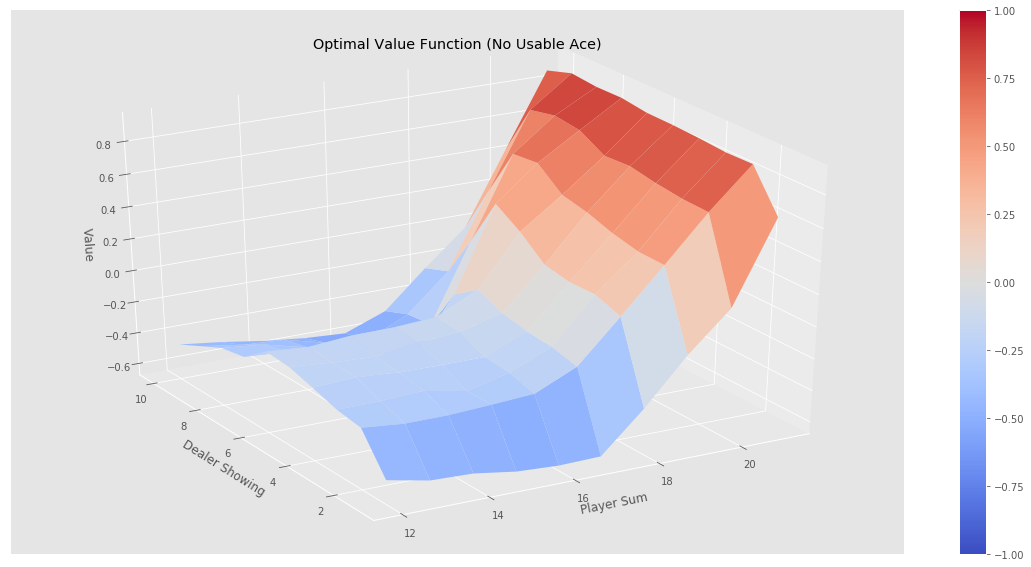

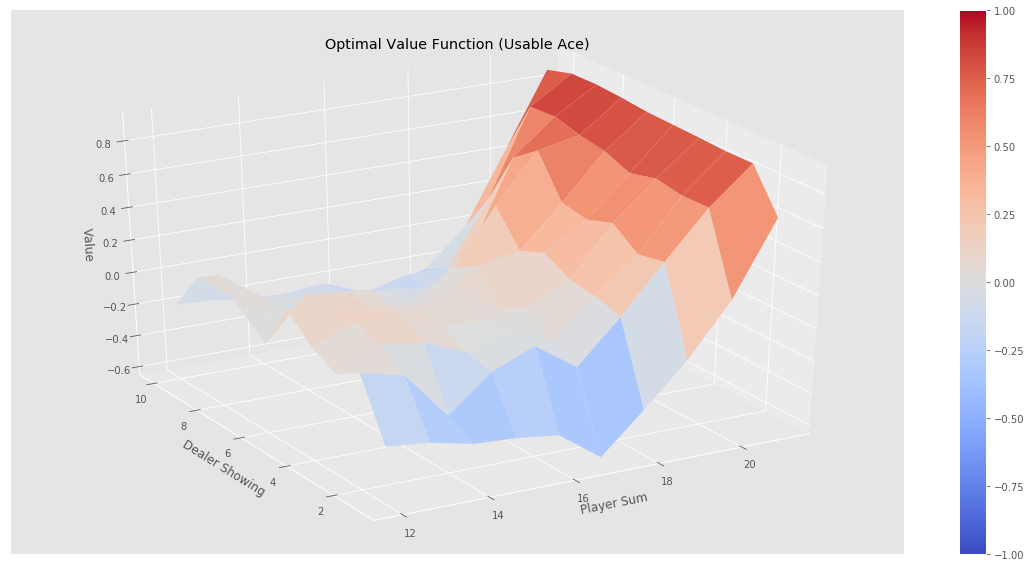

In [7]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")